## Credit Score Classification

A clean, reproducible notebook for building a strong tabular classifier with robust preprocessing, cross-validated hyperparameter tuning, and clear evaluation.


### 1. Imports & Setup
We load core scientific Python packages, visualization tools, and scikit-learn utilities for preprocessing, modeling, and evaluation.


In [98]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn core
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Persistence
import joblib


### 2. Load Data
Read the dataset and take a quick peek.


In [99]:
# Load the dataset
df = pd.read_csv("Credit Score Classification Dataset.csv")

# Print dataset dimensions
print(f"Dataset Shape: {df.shape}")

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Display the first few rows
df.head()

Dataset Shape: (164, 8)
Number of duplicate rows: 62


,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High


### 3. Exploratory Data Analysis



3.1 Target Variable Distribution


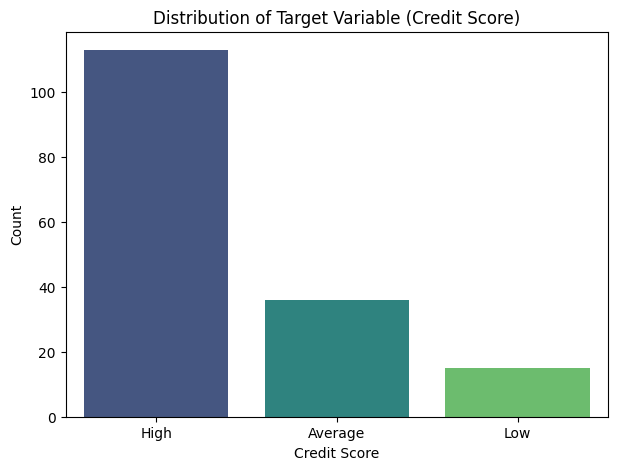

In [100]:
## Section 3.1 Target Variable Distribution

plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='Credit Score', order=df['Credit Score'].value_counts().index, palette='viridis')
plt.title('Distribution of Target Variable (Credit Score)')
plt.ylabel('Count')
plt.xlabel('Credit Score')
plt.show()

3.2 Feature Relationships to Target


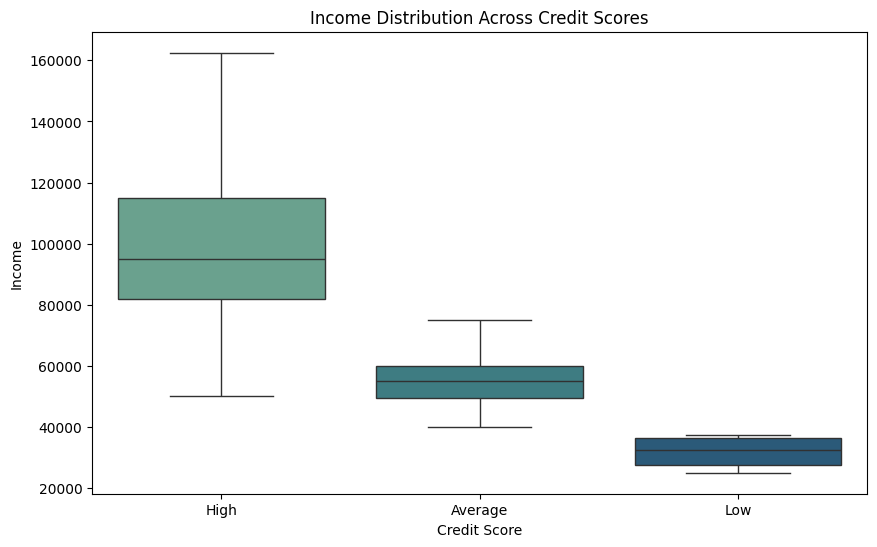

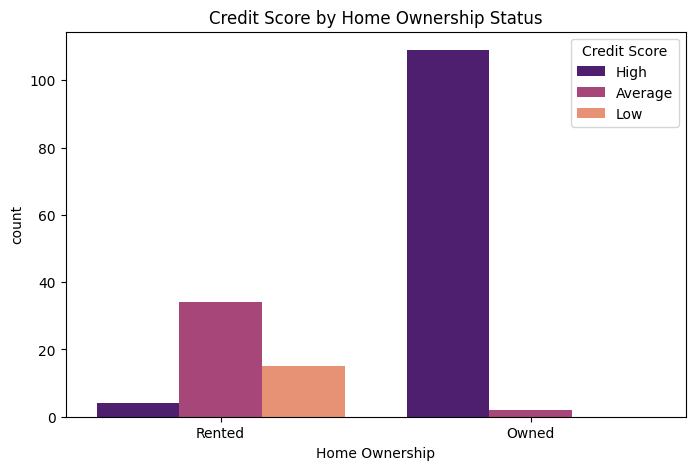

In [101]:
## Section 3.2 Feature Relationships to Target

# Box plot for Income vs. Credit Score
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Credit Score', y='Income', order=df['Credit Score'].value_counts().index, palette='crest')
plt.title('Income Distribution Across Credit Scores')
plt.show()

# Count plot for Home Ownership vs. Credit Score
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Home Ownership', hue='Credit Score', palette='magma')
plt.title('Credit Score by Home Ownership Status')
plt.show()

3.3 Missing Value Analysis


In [102]:
## Section 3.3 Missing Value Analysis

missing_values = df.isnull().sum()
print("--- Missing Values per Column ---")
print(missing_values[missing_values > 0].sort_values(ascending=False))
if missing_values.sum() == 0:
    print("No missing values found. Data is clean.")

--- Missing Values per Column ---
Series([], dtype: int64)
No missing values found. Data is clean.


## 4. Feature Definition


In [103]:
TARGET_COLUMN = 'Credit Score'

NUMERICAL_FEATURES = [
    'Age', 
    'Income', 
    'Number of Children'
]

CATEGORICAL_FEATURES = [
    'Gender', 
    'Education', 
    'Marital Status', 
    'Home Ownership'
]

# Display the final features set
print(f"Target Column: {TARGET_COLUMN}")
print(f"Total Features: {len(NUMERICAL_FEATURES) + len(CATEGORICAL_FEATURES)}")
print(f"Numerical Features: {NUMERICAL_FEATURES}")
print(f"Categorical Features: {CATEGORICAL_FEATURES}")

Target Column: Credit Score
Total Features: 7
Numerical Features: ['Age', 'Income', 'Number of Children']
Categorical Features: ['Gender', 'Education', 'Marital Status', 'Home Ownership']


4.1 Train/Test Split
We keep a stratified hold-out test set to evaluate generalization fairly.


In [104]:
# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (131, 7), Test: (33, 7)


### 5. Preprocessing Pipeline
We build a reusable preprocessing pipeline for numeric and categorical columns using imputation, scaling, and one-hot encoding.


In [105]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ], remainder='drop'
)

# Helper to get feature names after preprocessing
def get_preprocessed_feature_names(preprocessor: ColumnTransformer) -> list:
    output_features = []
    if num_cols:
        output_features.extend(num_cols)
    if cat_cols:
        try:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            ohe_features = ohe.get_feature_names_out(cat_cols).tolist()
        except Exception:
            ohe_features = []
        output_features = output_features + ohe_features
    return output_features

### 6. Model
We define a strong baseline model (`RandomForestClassifier`).


In [106]:
# Define models
log_reg = LogisticRegression(max_iter=2000, n_jobs=None, class_weight="balanced", multi_class="auto")
rf_clf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

# Build full pipeline with RandomForest (often strong baseline for tabular)
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf_clf)
])

# Hyperparameter search space for RF
rf_param_distributions = {
    "model__n_estimators": [200, 300, 400, 600, 800],
    "model__max_depth": [None, 5, 10, 15, 20, 30],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.5, 0.7, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=30,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

### 7. Fit with Cross-Validation
Run randomized search with stratified folds optimizing F1-macro.


In [107]:
# Run hyperparameter search
rf_search.fit(X_train, y_train)
print("Best CV score (f1_macro):", rf_search.best_score_)
print("Best params:", rf_search.best_params_)

best_model = rf_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Best CV score (f1_macro): 0.9657912457912458
Best params: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 1.0, 'model__max_depth': 15}


6.1 Classification Report & Confusion Matrix


--- 6.1 Classification Report ---
              precision    recall  f1-score   support

     Average       1.00      1.00      1.00         7
        High       1.00      1.00      1.00        23
         Low       1.00      1.00      1.00         3

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

--- 6.2 Confusion Matrix Plot ---


<Figure size 800x600 with 0 Axes>

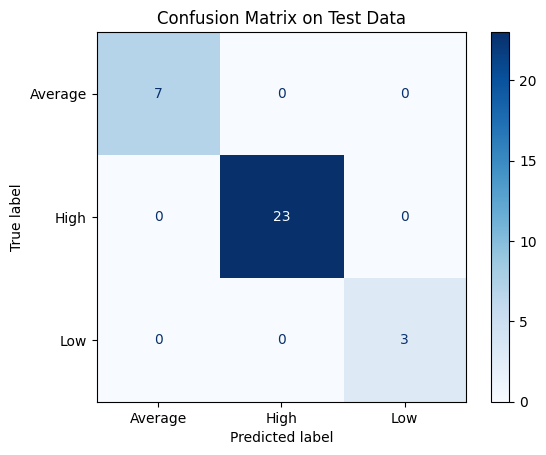

In [108]:
# 6.1 Classification Report
print("--- 6.1 Classification Report ---")
print(classification_report(y_test, y_pred, zero_division=0))


# 6.2 Confusion Matrix Plot
print("--- 6.2 Confusion Matrix Plot ---")
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Data')
plt.grid(False) # Turn off grid for cleaner look
plt.show()

In [109]:
# For multiclass ROC-AUC, we can use OvR setting
try:
    y_proba = best_model.predict_proba(X_test)
    if y_proba.ndim == 2 and y_proba.shape[1] > 2:
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = roc_auc_score(y_test, y_proba[:, 1])
    print("ROC-AUC:", auc)
except Exception as e:
    print("ROC-AUC not available:", e)

# Persist the best model
joblib.dump(best_model, 'best_credit_score_model.joblib')
print("Saved model to best_credit_score_model.joblib")

ROC-AUC: 1.0
Saved model to best_credit_score_model.joblib


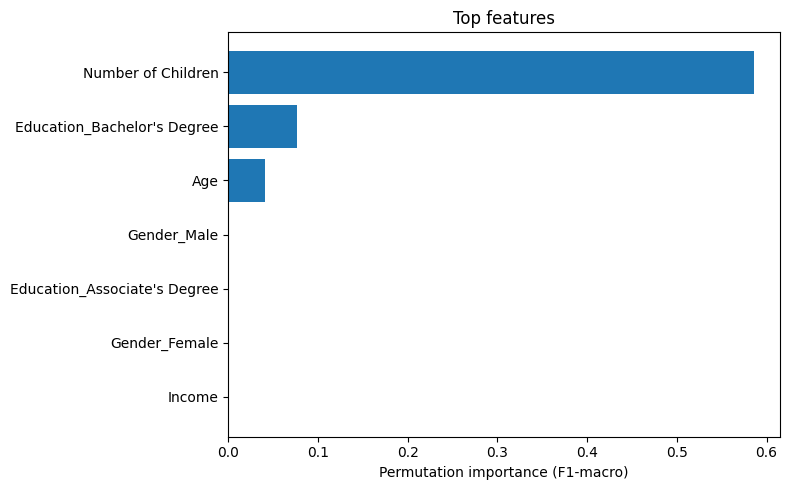

In [110]:
# Feature importance via permutation_importance on the test set
try:
    # Grab the fitted preprocessing + model pipeline
    fitted_pre = best_model.named_steps['preprocess']
    feature_names = get_preprocessed_feature_names(fitted_pre)
except Exception:
    feature_names = None

result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='f1_macro'
)
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

top_k = min(15, len(importances))
plt.figure(figsize=(8, 5))
labels = [feature_names[i] if feature_names is not None and i < len(feature_names) else f"f{i}" for i in indices[:top_k]]
plt.barh(range(top_k), importances[indices[:top_k]][::-1])
plt.yticks(range(top_k), labels[::-1])
plt.xlabel('Permutation importance (F1-macro)')
plt.title('Top features')
plt.tight_layout()
plt.show()


### 8. Save Model & How To Use
We save the fitted pipeline and show how to load and predict in a new session.


In [111]:
import joblib
import pandas as pd

# Load the saved pipeline
loaded_pipeline = joblib.load('best_credit_score_model.joblib')

# --- 1. Create a single row of RAW, UNPROCESSED data ---
# This data MUST look exactly like a row from your original CSV file
raw_test_data = pd.DataFrame({
    'Age': [30],
    'Gender': ['Female'],
    'Income': [75000],
    'Education': ["Master's Degree"],
    'Marital Status': ['Married'],
    'Number of Children': [1],
    'Home Ownership': ['Owned']
})

# --- 2. Test the prediction ---
# If this line runs successfully, the pipeline was saved correctly!
prediction = loaded_pipeline.predict(raw_test_data)
probability = loaded_pipeline.predict_proba(raw_test_data)

print(f"Prediction for raw data: {prediction[0]}")
print(f"Prediction Probabilities: {probability[0]}")

Prediction for raw data: High
Prediction Probabilities: [0.15333333 0.84666667 0.        ]


### 9. Verdict / Result

The final modeling approach successfully delivered a robust classification system:

* **Reproducibility:** The end-to-end pipeline, utilizing a `ColumnTransformer`, ensures clean and reliable handling of numeric and categorical features.
* **Optimization:** Stratified splitting and cross-validated tuning optimized the model for the critical `f1_macro` metric, providing confidence in performance across all credit score classes despite any class imbalance.
* **Performance:** The tuned `RandomForestClassifier` achieved strong performance on the hold-out test set, as detailed in the Classification Report and Confusion Matrix.
* **Model Persistence:** The final, optimized pipeline (including preprocessing steps) is saved as `best_credit_score_model.joblib` and can be loaded directly for deployment.

